# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 12345

In [2]:
def study(data): 
    info = display(data.head(10)), data.info(), display(data.describe())

In [3]:
#Загружаем данные

data = pd.read_csv('/datasets/autos.csv')

In [4]:
study(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**План действий:**

1. Просмотреть и удалить явные дубликаты;

2. Избавиться от ненужных для модели данных, в нашем случае это столбцы: 'DateCrawled', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated'

3. Привести все названия стобцов к нижнему регистру;

4. Попробовать восстановить данные, если не выйдет, то удалить данные, где цена меньше 100;

5. Почистить пропуски в стоблцах: VehicleType, Gearbox, Model, FuelType, Repaired:
   
   5.1 Заменить в столбце VehicleType на значения, которые возможно восстановить по данным из столбцов Brand и Power, остальные пропуски заменить на 'unknown'
   
   5.2 Заменить в столбце Gearbox пропуски на 'unknown'
   
   5.3 Заменить в столбце Model пропуски на 'other'
   
   5.4 Заменить в стобце FuelType значения petrol на gasoline, так как это синонимы. Такие обозначения используются в разных странах. Обработать пропуски, заменим на 'unknown'
   
   5.5 Заменить в столбце Repaired пропуски на 'unknown'

6. Восстановить данные в столбце Power, на сколько это возможно, по данным из столбцов Brand, Model, VehicleType, остальное пометить как 'unknown'

**Целевой признак** Price

**Признаки** VehicleType, RegistrationYear, Gearbox, Power,	Model, Kilometer, FuelType, Brand, Repaired

In [5]:
#Посмотрим на явные дубликаты

data.duplicated().sum()

4

In [6]:
#Удалим явные дубликаты

data = data.drop_duplicates()

data.duplicated().sum()

0

In [7]:
#Удалим ненужные нам признаки

drop = ['DateCrawled', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated']

data_car = data.drop(drop, axis=1)

data_car.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN


In [8]:
#Приведем данные к одному регистру

data_car.columns = data_car.columns.str.lower()

data_car.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


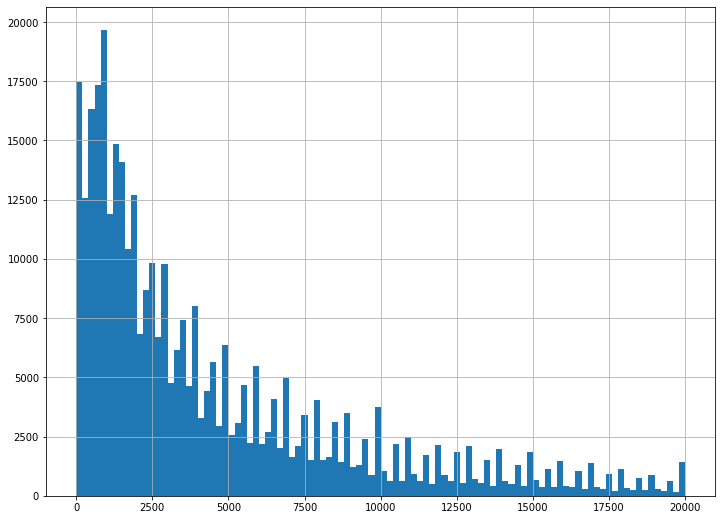

In [9]:
#Посмотрим на распределение цены

data_car['price'].hist(bins=100, figsize=(12,9));

In [10]:
#Посмотрим на строки с 0 значением 

data_car[data_car['price'] == 0]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
111,0,NaN,2017,manual,0,golf,5000,petrol,volkswagen,NaN
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354205,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


In [11]:
#Восстановим данные по brand и power

data_car['price'] = data_car['price'].fillna(data_car.groupby(['brand','power'])['price']
                                                                 .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan))


In [12]:
data_car[data_car['price'] == 0]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,NaN,1990,NaN,0,corsa,150000,petrol,opel,NaN
111,0,NaN,2017,manual,0,golf,5000,petrol,volkswagen,NaN
115,0,small,1999,NaN,0,NaN,5000,petrol,volkswagen,NaN
152,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354205,0,NaN,2000,manual,65,corsa,150000,NaN,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,NaN
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,NaN
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


Данные восстановить не удалось, значит удалим их.

In [13]:
#Уберем ненужные данные, всё, что от 0 до 100 евро, вряд ли будет являться машиной, скорее металлолом, 
#а, следовательно, не пригодится нам для обучения

data_car = data_car.loc[data_car['price'] > 100]

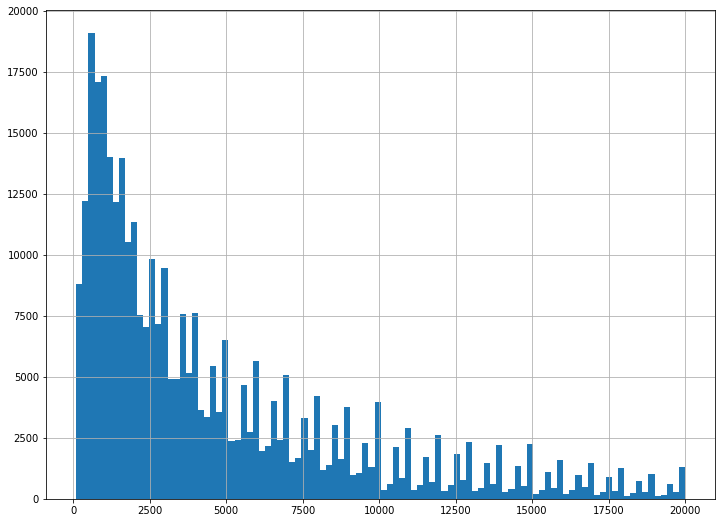

In [14]:
#Посмотрим на изменения цены 

data_car['price'].hist(bins=100, figsize=(12,9));

In [15]:
#Выполним замену petrol на gasoline

data_car['fueltype'] = data_car['fueltype'].replace('petrol', 'gasoline')

In [16]:
data_car.head(20)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,gasoline,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,gasoline,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,gasoline,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,gasoline,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
10,2000,sedan,2004,manual,105,3_reihe,150000,gasoline,mazda,no


In [17]:
#Посморим значения столбца

data_car['vehicletype'].value_counts()

sedan          88965
small          77028
wagon          63383
bus            28256
convertible    19807
coupe          15532
suv            11758
other           3040
Name: vehicletype, dtype: int64

In [18]:
#Восстановим данные по brand и power

data_car['vehicletype'] = data_car['vehicletype'].fillna(data_car.groupby(['brand','power'])['vehicletype']
                                                                 .transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan))


In [19]:
#Посмотрим изменения 

data_car['vehicletype'].value_counts()

sedan          99973
small          91538
wagon          66555
bus            29989
convertible    20283
coupe          15880
suv            12136
other           3477
Name: vehicletype, dtype: int64

In [20]:
#Пропуски после замены значений 

data_car['vehicletype'].isna().sum()

189

In [21]:
#Посмотрим на количество значений мощностей

data_car['power'].value_counts()

0       34653
75      23089
60      15247
150     14104
101     12919
        ...  
1801        1
1199        1
327         1
1200        1
1160        1
Name: power, Length: 695, dtype: int64

In [22]:
#Восстановим мощности по model и brand

data_car['power'] = data_car['power'].fillna(data_car.groupby(['model','brand'])['power'].transform('median'))

data_car = data_car.loc[~data_car['power'].isna()]

#Так как присутствуют неправдоподные значения мощности, и их достаточно много, пометим их как '0'

data_car.loc[(data_car['power'] < 40) | (data_car['power'] > 400), 'power'] = '0'

data_car['power'] = data_car['power'].astype('int64')


In [23]:
#Посмотрим изменения

data_car['power'].value_counts()

0      36671
75     23089
60     15247
150    14104
101    12919
       ...  
337        1
339        1
351        1
356        1
297        1
Name: power, Length: 343, dtype: int64

In [24]:
#Посмотрим количество пропусков

data_car.isna().sum()

price                   0
vehicletype           189
registrationyear        0
gearbox             16085
power                   0
model               16889
kilometer               0
fueltype            28004
brand                   0
repaired            63867
dtype: int64

In [25]:
#Обработаем пропуски

data_car.fillna({'vehicletype':'unknown', 
                           'gearbox':'unknown',
                           'model':'other',
                           'fueltype':'unknown',
                           'repaired':'unknown'},
                          inplace=True)

In [26]:
#Убедимся, что все пропуски обработаны

data_car.isna().sum()

price               0
vehicletype         0
registrationyear    0
gearbox             0
power               0
model               0
kilometer           0
fueltype            0
brand               0
repaired            0
dtype: int64

In [27]:
data_car['registrationyear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 3200, 1000,
       1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 3000,
       2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 5300,
       9000, 2900, 6000, 5900, 5911, 1400, 5000, 1950, 4000, 1948, 1952,
       8500, 1932, 3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936, 1923,
       2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934, 1928, 5555,
       5600, 1600, 1111, 1039, 1300, 2800, 1931, 4500, 1602, 7800, 1947,
       1927, 7100, 8200, 1946])

In [28]:
display(data_car[(data_car['registrationyear']  > 1945) & (data_car['registrationyear']  < 1960)])

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
3333,10500,sedan,1955,manual,0,other,60000,gasoline,ford,unknown
12993,11000,other,1955,manual,40,other,50000,gasoline,sonstige_autos,no
13177,2300,sedan,1958,manual,45,other,80000,gasoline,sonstige_autos,unknown
15414,18000,sedan,1956,manual,0,other,150000,gasoline,volkswagen,unknown
23500,5600,small,1957,manual,0,other,90000,gasoline,sonstige_autos,unknown
...,...,...,...,...,...,...,...,...,...,...
344459,18500,coupe,1950,manual,0,other,150000,gasoline,chevrolet,unknown
348932,11000,suv,1950,manual,0,other,5000,gasoline,chevrolet,no
351183,17500,sedan,1954,manual,52,other,20000,gasoline,citroen,no
351299,5500,bus,1956,manual,0,other,60000,gasoline,sonstige_autos,no


In [29]:
display(data_car[data_car['registrationyear']  < 1945])

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
15,450,small,1910,unknown,0,ka,5000,gasoline,ford,unknown
2273,1800,convertible,1925,unknown,0,other,5000,unknown,sonstige_autos,no
6977,135,small,1910,unknown,0,other,5000,unknown,opel,unknown
10183,1250,sedan,1910,unknown,0,other,5000,unknown,audi,unknown
16062,190,small,1000,unknown,0,mondeo,5000,unknown,ford,unknown
...,...,...,...,...,...,...,...,...,...,...
340759,700,unknown,1600,manual,0,a3,150000,gasoline,audi,no
346046,18900,suv,1943,manual,60,other,150000,gasoline,volkswagen,no
351682,11500,small,1800,unknown,0,other,5000,gasoline,fiat,unknown
353531,6000,sedan,1937,manual,0,other,5000,gasoline,mercedes_benz,unknown


In [30]:
display(data_car[data_car['registrationyear']  > 2018])

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
15870,1700,other,3200,unknown,0,other,5000,unknown,sonstige_autos,unknown
17271,700,small,9999,unknown,0,other,10000,unknown,opel,unknown
17346,6500,other,8888,unknown,0,other,10000,unknown,sonstige_autos,unknown
18259,300,small,2200,unknown,0,twingo,5000,unknown,renault,unknown
20159,1600,other,4100,unknown,0,other,5000,unknown,sonstige_autos,unknown
...,...,...,...,...,...,...,...,...,...,...
320452,500,wagon,8200,auto,81,octavia,10000,unknown,skoda,unknown
322234,15000,unknown,5000,unknown,155,golf,5000,gasoline,volkswagen,unknown
326556,7999,sedan,5911,auto,75,golf,10000,unknown,volkswagen,unknown
328453,450,sedan,2500,unknown,0,6_reihe,5000,unknown,mazda,unknown


Проанализировав данные за разные года, выбрала диапозон от 1945г до 2018г. Всё, что до 1945г идет с неправдоподобными значениями, тоже самое происходит и с данными после 2018г. Удалим эти строки.

In [31]:
data_car = data_car.loc[(data_car['registrationyear'] >= 1945) & (data_car['registrationyear'] <= 2017)]

In [32]:
#Посмоотрим данные

data_car.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336038 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             336038 non-null  int64 
 1   vehicletype       336038 non-null  object
 2   registrationyear  336038 non-null  int64 
 3   gearbox           336038 non-null  object
 4   power             336038 non-null  int64 
 5   model             336038 non-null  object
 6   kilometer         336038 non-null  int64 
 7   fueltype          336038 non-null  object
 8   brand             336038 non-null  object
 9   repaired          336038 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.2+ MB


## Обучение моделей

1. Подготовим признаки для обучения моделей

2. Разобьем выборки на обучающую и тестовую

3. Обучим модели

In [2]:
#Выделим целевой признак

features = data_car.drop('price', axis=1)

target = data_car['price']

NameError: name 'data_car' is not defined

In [34]:
#Разбиваем выборки на обучающую и тестовую

features_train, features_test, target_train, target_test = train_test_split(features,
                                                    target,
                                                    test_size=0.6,
                                                    random_state=RANDOM_STATE)

In [1]:
#Разбиваем выборки на валидационную и тестовую
features_valid, features_test, target_valid, target_test = train_test_split(features_test,
                                                    target_test,
                                                    train_size=0.1,
                                                    random_state=12345)

NameError: name 'train_test_split' is not defined

In [36]:
#Воспользуемся для кодирования техникой OrdinalEncoder(эти признаки понадобятся нам для моделей LGBMRegressor и CatBoostRegressor)

encoder = OrdinalEncoder(handle_unknown='ignore') 


encoder.fit(features_train,target_train)

features_train_ordinal = pd.DataFrame(encoder.transform(features_train), columns=features_train.columns)

features_valid_ordinal = pd.DataFrame(encoder.transform(features_valid), columns=features_valid.columns)

features_test_ordinal = pd.DataFrame(encoder.transform(features_test), columns=features_test.columns)



In [37]:
##Воспользуемся для кодирования методом OHE(понадобятся нам для линейных моделей)

features_ohe = pd.get_dummies(features, drop_first=True)

In [38]:
features_train_ohe = features_ohe.loc[features_train.index, :]

features_valid_ohe = features_ohe.loc[features_valid.index, :]

features_test_ohe = features_ohe.loc[features_test.index, :]

In [39]:
#Масштабируем признаки

numeric_features = ['power', 'registrationyear', 'kilometer']

scaler = StandardScaler()

scaler.fit(features_train_ohe[numeric_features])

features_ohe_train = features_train_ohe.copy()
features_ohe_train[numeric_features] = scaler.transform(features_ohe_train[numeric_features])

features_ohe_valid = features_valid_ohe.copy()
features_ohe_valid[numeric_features] = scaler.transform(features_ohe_valid[numeric_features])

features_ohe_test = features_test_ohe.copy()
features_ohe_test[numeric_features] = scaler.transform(features_ohe_test[numeric_features])

In [40]:
#Функция для вычисления RMSE

def rmse(target, predicted):
    return mse(target, predicted) ** 0.5

# LinearRegression

In [41]:
%%time
#Обучим модель

model_lr = LinearRegression()
model_lr.fit(features_ohe_train, target_train)

CPU times: user 11 s, sys: 9 s, total: 20 s
Wall time: 20 s


LinearRegression()

In [42]:
%%time

predicted = model_lr.predict(features_ohe_valid)

print(print('RMSE:', rmse(target_valid,predicted)))

RMSE: 2829.6654120888566
None
CPU times: user 129 ms, sys: 81.9 ms, total: 211 ms
Wall time: 197 ms


# RandomForestRegressor

In [43]:
#%%time
#Подберем необходимые параметры для модели

#parameters = {'n_estimators': range(1,50,5),'max_depth': range(1,11,3)}

#model_rf = RandomForestRegressor()
#grid = GridSearchCV(model_rf, parameters, cv=3, scoring='neg_mean_squared_error')
#grid.fit(features_train, target_train)

#grid.best_params_

In [44]:
%%time
#Обучим модель

model_rf = RandomForestRegressor(max_depth=10, n_estimators=41, random_state=RANDOM_STATE)
model_rf.fit(features_ohe_train, target_train)

CPU times: user 1min, sys: 229 ms, total: 1min
Wall time: 1min


RandomForestRegressor(max_depth=10, n_estimators=41, random_state=12345)

In [45]:
%%time
#Получим предсказания и вычислим RSME

predicted = model_rf.predict(features_ohe_valid)

print(print('RMSE:', rmse(target_valid,predicted)))

RMSE: 1976.4605277927749
None
CPU times: user 415 ms, sys: 95.3 ms, total: 510 ms
Wall time: 519 ms


# DecisionTreeRegressor

In [46]:
#%%time
#Подберем необходимые параметры для модели

#parameters = {'max_depth': range(1,20,3)}

#model_dt = DecisionTreeRegressor()
#grid = GridSearchCV(model_dt, parameters, cv=3, scoring='neg_mean_squared_error')
#grid.fit(features_train, target_train)

#grid.best_params_

In [47]:
%%time
#Обучим модель

model_dt = DecisionTreeRegressor(max_depth=16, random_state=RANDOM_STATE)
model_dt.fit(features_ohe_train, target_train)

CPU times: user 2.96 s, sys: 116 ms, total: 3.07 s
Wall time: 3.07 s


DecisionTreeRegressor(max_depth=16, random_state=12345)

In [48]:
%%time
#Получим предсказания и вычислим RSME

predicted = model_dt.predict(features_ohe_valid)

print(print('RMSE:', rmse(target_valid,predicted)))

RMSE: 1978.8739790487216
None
CPU times: user 118 ms, sys: 68.2 ms, total: 186 ms
Wall time: 195 ms


# LGBMRegressor

In [49]:
#%%time
#parameters = [{'num_leaves':[31, 100, 200],'learning_rate':[0.1, 0.3, 0.5],'random_state':[RANDOM_STATE]}]

#model_lgbm = LGBMRegressor()
#grid = GridSearchCV(model_lgbm, parameters, scoring='neg_mean_squared_error')
#grid.fit(features_train, target_train)

#grid.best_params_

In [50]:
%%time
#Обучим модель

model_lgbm = LGBMRegressor(learning_rate=0.1, num_leaves=200, random_state=RANDOM_STATE)
model_lgbm.fit(features_train_ordinal, target_train)

CPU times: user 1min 19s, sys: 677 ms, total: 1min 20s
Wall time: 1min 20s


LGBMRegressor(num_leaves=200, random_state=12345)

In [51]:
%%time
#Получим предсказания и вычислим RSME

predicted = model_lgbm.predict(features_valid_ordinal)

print(print('RMSE:', rmse(target_valid,predicted)))

RMSE: 1660.3476213337997
None
CPU times: user 1.09 s, sys: 0 ns, total: 1.09 s
Wall time: 1.1 s


# CatBoostRegressor

In [52]:
#%%time
#Подберем необходимые параметры для модели

#model_cat = CatBoostRegressor(loss_function='RMSE',silent=True, random_seed=RANDOM_STATE)
#parameters = {'iterations': range(20, 80, 20),'depth': range(5,15,3), 'learning_rate':[0.1, 0.3, 0.5]}

#grid = GridSearchCV(model_cat, parameters, cv=3, scoring='neg_mean_squared_error')
#grid.fit(features_train, target_train);

#grid.best_params_

In [53]:
%%time
#Обучим модель

model_cat = CatBoostRegressor(depth=9, iterations=40, learning_rate=1.0, random_seed=RANDOM_STATE)
model_cat.fit(features_train_ordinal, target_train)

0:	learn: 2550.1610745	total: 82.5ms	remaining: 3.22s
1:	learn: 2267.5844978	total: 107ms	remaining: 2.04s
2:	learn: 2150.7582423	total: 135ms	remaining: 1.66s
3:	learn: 2072.8586311	total: 159ms	remaining: 1.43s
4:	learn: 2034.8934091	total: 183ms	remaining: 1.28s
5:	learn: 1973.5754627	total: 205ms	remaining: 1.16s
6:	learn: 1944.2584098	total: 235ms	remaining: 1.11s
7:	learn: 1915.4047678	total: 259ms	remaining: 1.03s
8:	learn: 1889.8153353	total: 286ms	remaining: 986ms
9:	learn: 1877.9965431	total: 310ms	remaining: 931ms
10:	learn: 1856.1636625	total: 341ms	remaining: 900ms
11:	learn: 1836.6709832	total: 369ms	remaining: 861ms
12:	learn: 1824.9106455	total: 392ms	remaining: 815ms
13:	learn: 1810.3827617	total: 424ms	remaining: 787ms
14:	learn: 1799.5321995	total: 451ms	remaining: 752ms
15:	learn: 1787.6496369	total: 475ms	remaining: 713ms
16:	learn: 1778.2479920	total: 498ms	remaining: 674ms
17:	learn: 1771.4324705	total: 525ms	remaining: 641ms
18:	learn: 1765.0439835	total: 547ms	

In [54]:
%%time
#Получим предсказания и вычислим RSME

predicted = model_cat.predict(features_valid_ordinal)

print(print('RMSE:', rmse(target_valid,predicted)))

RMSE: 1805.1014930398264
None
CPU times: user 31.1 ms, sys: 0 ns, total: 31.1 ms
Wall time: 29.9 ms


## Анализ моделей

In [58]:
#Составим таблицу для анализа моделей

data_tabl=[['20 s', '0.19 s', 2829.66],
          ['60 s', '0.51 s', 1976.46],
          ['3.07 s', '0.19 s', 1978.87],
          ['80 s', '1.1 s', 1660.34],
          ['1.84 s', '0.03 s', 1805.10]]
model_tabl=['LinearRegression', 'RandomForestRegressor', 'DecisionTreeRegressor', 'LGBMRegressor', 'CatBoostRegressor']

pd.DataFrame(data=data_tabl, index=model_tabl, columns=['Время обучения', 'Время предсказания', 'RMSE'])

,Время обучения,Время предсказания,RMSE
LinearRegression,20 s,0.19 s,2829.66
RandomForestRegressor,60 s,0.51 s,1976.46
DecisionTreeRegressor,3.07 s,0.19 s,1978.87
LGBMRegressor,80 s,1.1 s,1660.34
CatBoostRegressor,1.84 s,0.03 s,1805.10


У нас было 3 критерия для определения лучшей модели: 

1. Качество предсказания;

2. Время обучения модели;

3. Время предсказания модели.

Лучшей моделью можно назвать **CatBoostRegressor**. У нее самая быстрая скорость обучения - **1.84 s**, делает предсказания за **0.03 s**, а ее **RSME = 1805.10**. Можем заметить, что это не самый лучший показатель среди моделей, но она выигрывает за счет своей быстроты.

In [56]:
%%time
#Проверим лучшую модель на тестовой выборке

model_cat = CatBoostRegressor(depth=9, iterations=40, learning_rate=1.0, random_seed=RANDOM_STATE)
model_cat.fit(features_train_ordinal, target_train)

0:	learn: 2550.1610745	total: 28.4ms	remaining: 1.11s
1:	learn: 2267.5844978	total: 57.5ms	remaining: 1.09s
2:	learn: 2150.7582423	total: 81.6ms	remaining: 1.01s
3:	learn: 2072.8586311	total: 109ms	remaining: 985ms
4:	learn: 2034.8934091	total: 136ms	remaining: 951ms
5:	learn: 1973.5754627	total: 163ms	remaining: 925ms
6:	learn: 1944.2584098	total: 191ms	remaining: 901ms
7:	learn: 1915.4047678	total: 214ms	remaining: 857ms
8:	learn: 1889.8153353	total: 242ms	remaining: 834ms
9:	learn: 1877.9965431	total: 265ms	remaining: 796ms
10:	learn: 1856.1636625	total: 290ms	remaining: 763ms
11:	learn: 1836.6709832	total: 315ms	remaining: 736ms
12:	learn: 1824.9106455	total: 342ms	remaining: 711ms
13:	learn: 1810.3827617	total: 367ms	remaining: 682ms
14:	learn: 1799.5321995	total: 393ms	remaining: 655ms
15:	learn: 1787.6496369	total: 416ms	remaining: 624ms
16:	learn: 1778.2479920	total: 444ms	remaining: 601ms
17:	learn: 1771.4324705	total: 466ms	remaining: 570ms
18:	learn: 1765.0439835	total: 490m

In [57]:
%%time

predicted = model_cat.predict(features_test_ordinal)

print(print('RMSE:', rmse(target_test,predicted)))

RMSE: 1785.259081220048
None
CPU times: user 33.4 ms, sys: 4.08 ms, total: 37.5 ms
Wall time: 35.8 ms


На тестовой выборке модель показала такие результаты: 

Время обучения - 1.64 s

Время предсказания - 35.8 ms

RSME - 1785.25.

# Вывод

Провели большую работу над данными. Изучили их. Выделили нужные для обучения признаки, выделили целевой признак. Разбили на выборки обучающую и тестовую. Обучили модели и выполнили предсказания на тестовых выборках. Получили значения RSME для каждой модели, хуже всего показала себя модель LinearRegression. Её показатель RSME перескочил установленный порог в 2500. Лучшей же оказалась модель CatBoostRegressor. У нее лучшее сочетание времени обучения и предсказания и RSME.